[*********************100%***********************]  1 of 1 completed
╒═══════╤══════════════════════╤════════════════════════╤═══════════════════════╕
│       │  Daily Volatility %  │  Monthly Volatility %  │  Annual Volatility %  │
╞═══════╪══════════════════════╪════════════════════════╪═══════════════════════╡
│ Tesla │         3.82         │         17.52          │         60.69         │
╘═══════╧══════════════════════╧════════════════════════╧═══════════════════════╛
mu          0.170958
omega       0.306428
alpha[1]    0.052980
beta[1]     0.926470
Name: params, dtype: float64


                  h.1        h.2        h.3        h.4        h.5
Date                                                             
2023-07-28  12.353774  12.406323  12.457792  12.508203  12.557578


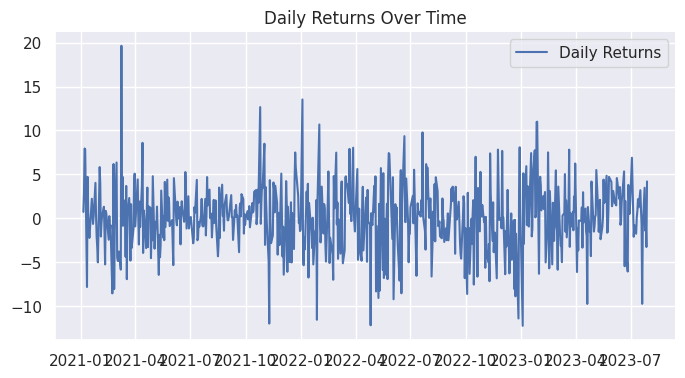

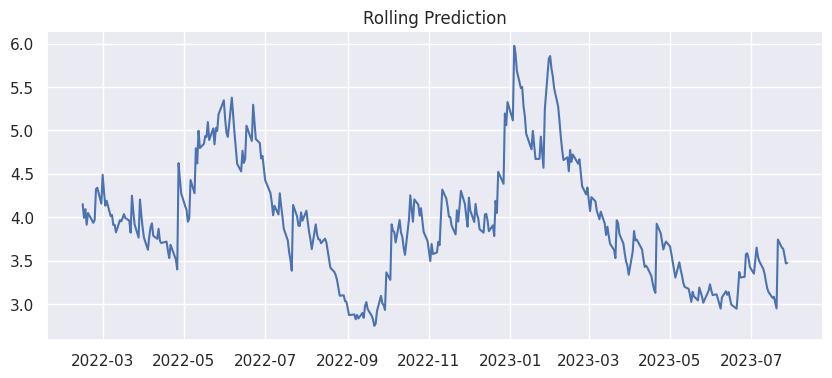

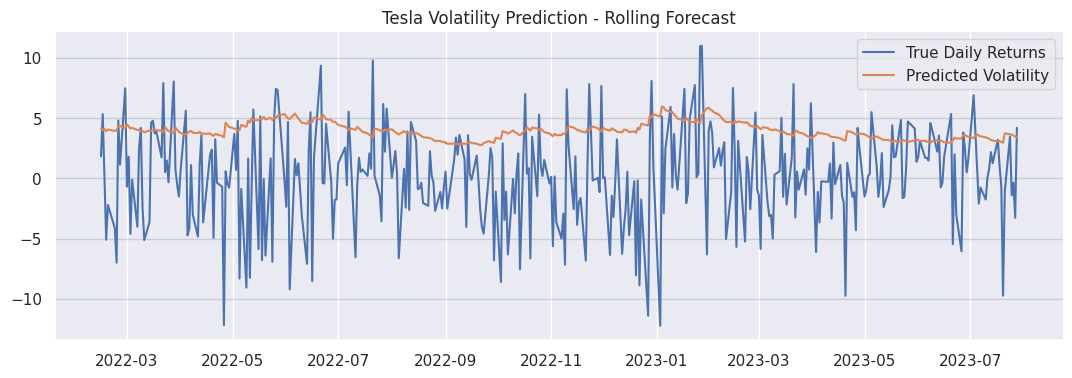

In [42]:
!pip install arch
from arch import arch_model
from arch.__future__ import reindexing
import yfinance as yf
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#%matplotlib inlin
ticker= "tsla"
tsla_data = yf.download(ticker, start="2021-01-01", end="2023-07-30")
tsla_data['Return'] = 100 * (tsla_data['Close'].pct_change())
tsla_data.dropna(inplace=True)

fig,ax = plt.subplots(figsize=(8,4))
ax.spines[['top','right']].set_visible(False)
plt.plot(tsla_data['Return'], label = 'Daily Returns')
plt.legend(loc='upper right')
plt.title('Daily Returns Over Time')
daily_volatility = tsla_data['Return'].std()

monthly_volatility = math.sqrt(21) * daily_volatility

annual_volatility = math.sqrt(252) * daily_volatility

from tabulate import tabulate

print(tabulate([['Tesla',daily_volatility,monthly_volatility,annual_volatility]],headers = ['Daily Volatility %', 'Monthly Volatility %', 'Annual Volatility %'],tablefmt = 'fancy_grid',stralign='center',numalign='center',floatfmt=".2f"))

garch_model = arch_model(tsla_data['Return'], p = 1, q = 1,
                      mean = 'constant', vol = 'GARCH', dist = 'normal')

gm_result = garch_model.fit(disp='off')
print(gm_result.params)

print('\n')

gm_forecast = gm_result.forecast(horizon = 5)
print(gm_forecast.variance[-1:])
rolling_predictions = []
test_size = 365

for i in range(test_size):
    train = tsla_data['Return'][:-(test_size-i)]
    model = arch_model(train, p=1, q=1)
    model_fit = model.fit(disp='off')
    pred = model_fit.forecast(horizon=1)
    rolling_predictions.append(np.sqrt(pred.variance.values[-1,:][0]))

rolling_predictions = pd.Series(rolling_predictions, index=tsla_data['Return'].index[-365:])

fig,ax = plt.subplots(figsize=(10,4))
ax.spines[['top','right']].set_visible(False)
plt.plot(rolling_predictions)
plt.title('Rolling Prediction')

fig,ax = plt.subplots(figsize=(13,4))
ax.grid(which="major", axis='y', color='#758D99', alpha=0.3, zorder=1)
ax.spines[['top','right']].set_visible(False)
plt.plot(tsla_data['Return'][-365:])
plt.plot(rolling_predictions)
plt.title('Tesla Volatility Prediction - Rolling Forecast')
plt.legend(['True Daily Returns', 'Predicted Volatility'])